Messing around with the applicability of the shortest path algorithm to the LABS problem

Based on https://arxiv.org/pdf/2212.01513.pdf

In [17]:
import os

os.environ["OMP_NUM_THREADS"] = "20"

import sys
sys.path.append("../code/")

from utils import get_adjusted_state
from objectives import get_precomputed_labs_energies, get_precomputed_optimal_bitstrings
from matrix import X as Pauli_X 
from matrix import I as Pauli_I 
from matrix import kron
import numpy as np
import pickle
from functools import reduce

def g_eta(x, eta):
    # Eq 4 of https://arxiv.org/pdf/2212.01513.pdf
    return np.minimum(np.zeros(x.shape), (x+1-eta)/eta)

N = 13

X = sum(
        kron(*([Pauli_I] * i + [Pauli_X] + [Pauli_I] * (N - i - 1)))
        for i in range(N)
)

plus = np.ones(2**N) / 2**(N/2)
assert np.isclose(plus.T.dot(plus), 1)

H_diag = get_adjusted_state(
    get_precomputed_labs_energies(N)
)

precomputed_bitstrings = get_precomputed_optimal_bitstrings(N)

H_diag -= sum(H_diag) / len(H_diag)
assert np.isclose(sum(H_diag), 0)

# compute the ground state of H
gs_of_H = np.zeros(2**N)

bitstring_loc = np.array([reduce(lambda a, b: 2 * a + b, x) for x in precomputed_bitstrings])

for i in range(len(bitstring_loc)):
    gs_of_H[bitstring_loc[i]] = 1

gs_of_H /= np.sqrt(gs_of_H.dot(gs_of_H))
gs_of_H = get_adjusted_state(gs_of_H)

P = np.outer(gs_of_H, gs_of_H)

In [18]:
eta = 0.75

eigenvals = []
overlaps_with_plus = []
norms_projected = []
condition_1_satisfied = []

# bs = np.logspace(-2, 0, 20)
bs = np.linspace(0, 1, 30)
# bs = [0]

for b in bs:
    print(f"b={b:.5f}")
    H_b = - X / N + np.diag(b * g_eta(H_diag / np.abs(np.min(H_diag)), eta))

    # check that it's Hermitian and we did not mess up
    # assert np.all(np.isreal(H_b))
    # assert np.all(H_b == H_b.T)

    u,v = np.linalg.eigh(H_b)
    
    # check that eigenvalue / eigenvector pairs are interpreted correctly
    idx = 0
    eigvec = v[:, idx]
    assert np.all(np.isclose((H_b.dot(eigvec) - u[idx]*eigvec), np.zeros(eigvec.shape)))

    # Condition 1:
    # the ground-state of Hb is non-degenerate and all excited states have energy greater than −1 + 1/n

    unique_eigvals = sorted(set(np.round(u, 6)))[:3]
    condition_1 = unique_eigvals[1] > -1 + 1/N
    print(np.round(unique_eigvals, 3), condition_1)
    eigenvals.append(unique_eigvals)
    # assert condition_1
    condition_1_satisfied.append(condition_1)

    overlap_with_plus = np.abs(plus.dot(v[:, 0]))
    print("<+|psi_b> = ", overlap_with_plus)
    overlaps_with_plus.append(overlap_with_plus)

    norm_projected = np.linalg.norm(P.dot(v[:, 0]))
    print("||Pi |psi_b>|| = ", norm_projected)
    norms_projected.append(norm_projected)

b=0.00000
[-1.    -0.846 -0.692] True
<+|psi_b> =  1.0
||Pi |psi_b>|| =  0.022097086912079646
b=0.03448
[-1.    -0.846 -0.846] True
<+|psi_b> =  0.9999995149662867
||Pi |psi_b>|| =  0.022966285955234186
b=0.06897
[-1.    -0.846 -0.846] True
<+|psi_b> =  0.9999979135359127
||Pi |psi_b>|| =  0.023906689350458595
b=0.10345
[-1.    -0.847 -0.847] True
<+|psi_b> =  0.9999949337643054
||Pi |psi_b>|| =  0.02492741259759687
b=0.13793
[-1.    -0.847 -0.847] True
<+|psi_b> =  0.9999902433749103
||Pi |psi_b>|| =  0.02603919466138108
b=0.17241
[-1.    -0.847 -0.847] True
<+|psi_b> =  0.9999834174802368
||Pi |psi_b>|| =  0.027254775754006297
b=0.20690
[-1.    -0.847 -0.847] True
<+|psi_b> =  0.9999739079535269
||Pi |psi_b>|| =  0.028589385602872868
b=0.24138
[-1.    -0.847 -0.847] True
<+|psi_b> =  0.9999610007641487
||Pi |psi_b>|| =  0.030061381770015633
b=0.27586
[-1.    -0.848 -0.848] True
<+|psi_b> =  0.9999437556820373
||Pi |psi_b>|| =  0.031693094626175186
b=0.31034
[-1.    -0.848 -0.848] Tru

Text(0.5, 0, 'b')

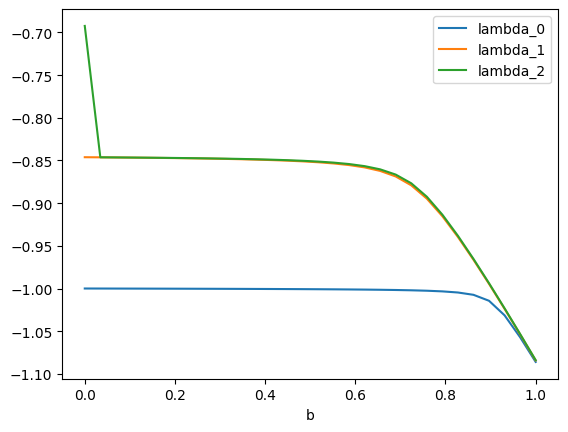

In [23]:
import matplotlib.pyplot as plt

for i in range(len(eigenvals[0])):
    plt.plot(bs, [x[i] for x in eigenvals], label=f'lambda_{i}')
plt.legend()
plt.xlabel('b')

Text(0.5, 0, 'b')

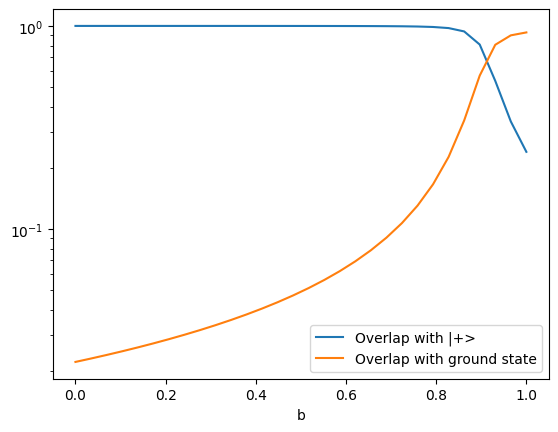

In [24]:
plt.plot(bs, overlaps_with_plus, label='Overlap with |+>')
plt.plot(bs, norms_projected, label='Overlap with ground state')
plt.legend()
plt.yscale('log')
plt.xlabel('b')

# Estimate coefficient alpha in alpha-depolarizing objective

Desired: E H(y)=(1−α)H(x) (see Eq 7 in https://arxiv.org/pdf/2212.01513.pdf)

In [29]:
import scipy
from copy import deepcopy

from labs import merit_factor, energy_vals, get_energy_term_indices
from functools import partial

def get_random_seq_of_spins(N):
    return [np.random.choice([-1,1]) for _ in range(N)]

def flip_random_spin(s):
    snew = deepcopy(s)
    idx = np.random.randint(0, high=len(s))
    snew[idx] *= -1
    return snew

In [30]:
alphas_stats = []
for N in np.arange(5,100,5):
    
    terms, offset = get_energy_term_indices(N)
    get_en = partial(energy_vals, terms=terms, offset=offset, check_parameters=False)
    
    alphas = []
    for _ in range(20):
        s = get_random_seq_of_spins(N)
        E = get_en(s)
        E_flipped = np.mean([get_en(flip_random_spin(s)) for _ in range(50)])

        E, E_flipped
        alphas.append(1 - E_flipped/E)

    alphas_stats.append(deepcopy(scipy.stats.describe(alphas)))
    print(N, alphas_stats[-1].minmax)

5 (-8.8, 0.872)
10 (-2.129230769230769, 0.4785321100917431)
15 (-2.0069565217391303, 0.28663101604278074)
20 (-0.4391836734693877, 0.2594475138121547)
25 (-0.3474999999999999, 0.1886131386861314)
30 (-0.26995260663507104, 0.15685452162516378)
35 (-0.24172307692307693, 0.07285913528591359)
40 (-0.1554716981132076, 0.10872246696035248)
45 (-0.13025641025641033, 0.06873885350318476)
50 (-0.08952601156069373, 0.0967214367596484)
55 (-0.171264667535854, 0.1100528128587831)
60 (-0.07492682926829275, 0.045343629343629344)
65 (-0.06459016393442618, 0.06746817538896754)
70 (-0.06479256965944269, 0.03024614374794876)
75 (-0.04227725956899331, 0.04371502468845523)
80 (-0.05567451820128477, 0.04544444444444451)
85 (-0.08130143540669854, 0.04715016551309048)
90 (-0.06749300279888049, 0.04199961984413614)
95 (-0.046551997883037766, 0.018437086092715216)


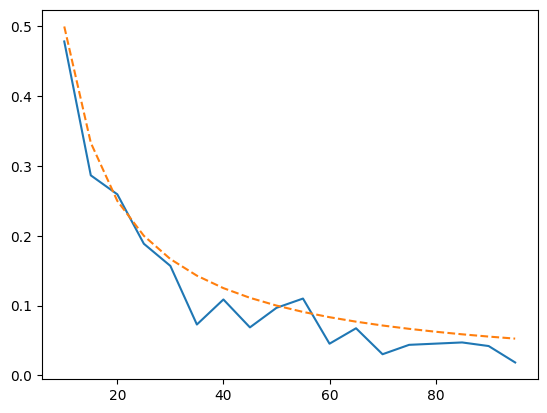

In [31]:
Ns = np.arange(5,100,5)[1:]
plt.plot(Ns, [x.minmax[1] for x in alphas_stats[1:]])
plt.plot(Ns, [5/N for N in Ns], linestyle='dashed')

Estimated $\alpha = 5/N$. Compare with MAX-4-LIN2 is alpha-depolarizing with $\alpha=8/N$

In [32]:
print(f"Estimated scaling: {2**(0.5-0.8*0.75/(2*5*np.log(2))):.2f}**N")
print(f"Quantum-accelerated branch-and-bound: {np.sqrt(1.73):.2f}**N")

Estimated scaling: 1.33**N
Quantum-accelerated branch-and-bound: 1.32**N


Better scaling may be possible if the alpha-depolarization factor can be carefully estimated

# Debugging

In [44]:
import sys
sys.path.append("../code/")

import numpy as np
from matrix import X as Pauli_X 
from matrix import I as Pauli_I 
from matrix import kron

N = 9

H = -sum(
        kron(*([Pauli_I] * i + [Pauli_X] + [Pauli_I] * (N - i - 1)))
        for i in range(N)
)

assert np.all(np.isreal(H))
assert np.all(H == H.T)

plus = np.ones(2**N) / 2**(N/2)
assert np.isclose(plus.T.dot(plus), 1)

u, v = np.linalg.eigh(H)
plus.dot(v[:, 0])

1.0